In [563]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points, plotting_positions, Weibull_probability_plot
from reliability.Utils import axes_transforms, probability_plot_xylims, probability_plot_xyticks, linear_regression
from reliability.Distributions import Weibull_Distribution

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler
from matplotlib import colors, colormaps
import matplotlib.ticker as mticker
import pandas as pd
from matplotlib.figure import figaspect
import seaborn as sns
import numpy as np
from scipy.special import gamma
from scipy.stats import weibull_min, linregress
from scipy.optimize import minimize
import itertools
import math
from shapely import Polygon
from shapely.plotting import plot_polygon
from collections import namedtuple
from sklearn.metrics import r2_score
import re

In [564]:
weib_params = namedtuple("weib_params", ['sigma', "mod", "sample_size"])

In [565]:
gage_length = 25

standard_dia = 1

standard_v = (standard_dia/2)**2 * np.pi * gage_length
standard_sa = standard_dia * np.pi * gage_length

design_prob = 1-0.05 ## Desired quantile of survival for design
arbitrary_prob = 0.5

In [566]:
stress_label = "Failure stress (MPa)"
v_label = "Volume ($mm^3$)"
sa_label = "Surface area ($mm^2$)"

In [567]:
marker_cycler = itertools.cycle(("^", "o", "x", "+"))

In [568]:
plt.style.use('seaborn-v0_8-ticks')
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["scatter.marker"] = "."

# Load and clean data

In [569]:
fibre_data = pd.read_excel("Fibre_data_V4.xlsx")

In [570]:
fibre_data.drop(columns=["test_num"], inplace=True)

In [571]:
def clean_sample_names(df):
    segs = re.split(r"\W", df["sample"])
    if len(segs) == 3:
        sample_ID = segs[0] + segs[1]
        sample_num = int(segs[2])
    else:
        sample_ID = segs[0]
        sample_num = int(segs[1])

    return sample_ID, sample_num

In [572]:
# fibre_data[["series", "series_num"]] = fibre_data.apply(clean_sample_names, axis=1, result_type="expand")

In [573]:
def sample_volume(length, dia):
    return np.pi * (dia/2)**2 * length

def sample_area(length, dia):
    return np.pi* dia * length

In [574]:
calc_size_helper = lambda row: [sample_volume(gage_length, row["fracture_diameter"]), sample_area(gage_length, row["fracture_diameter"])]

fibre_data[["gage_V", "gage_SA"]] = fibre_data.apply(calc_size_helper, axis=1, result_type="expand")

In [575]:
# fibre_data.drop(fibre_data[fibre_data["series"] == "Favimat"].index, inplace=True)

# fibre_data.drop(fibre_data[fibre_data["series"] == "Favimat2"].index, inplace=True)

# fibre_data.drop(fibre_data[fibre_data["series"] == "L2"].index, inplace=True)

fibre_data.drop(fibre_data[fibre_data["series"] == "C"].index, inplace=True)

fibre_data.drop(fibre_data[fibre_data["series"] == "A"].index, inplace=True)

# fibre_data.drop(fibre_data[fibre_data["series"] == "X"].index, inplace=True)

# fibre_data.drop(fibre_data[fibre_data["series"] == "S1"].index, inplace=True)

# fibre_data.drop(fibre_data[fibre_data["series"] == "S2"].index, inplace=True)

In [576]:
g1 = ["S1", "S2", "F1", "F2"]

g2 = ["L1", "L2", "X1", "X2", "C", "A"]

# Simple strength plots

In [577]:
def fit_and_plot_weibull(data, design_failure):
    ### Big function to fit and plot the needed weibull distributions of each series. Saves a figure of individual and collated distributions

    ## Set up matplotlib figures and axes
    ind_fig, ind_ax = plt.subplots()
    collated_fig, collated_ax = plt.subplots()
    
    ## Create a separate dataframe with statistics considering the entire series
    data_anal = data[["series", "fracture_diameter", "fracture_stress"]].groupby("series").agg(['mean', "std", "min", "max"])
    data_anal.columns = data_anal.columns.map('_'.join)
    data_anal["fracture_stress_CV"] = data_anal["fracture_stress_std"] / data_anal["fracture_stress_mean"] * 100
    data_anal["fracture_diameter_CV"] = data_anal["fracture_diameter_std"] / data_anal["fracture_diameter_mean"] * 100

    ## Sort the values to display nicer in figure legends
    data_anal = data_anal.sort_values("fracture_diameter_mean")

    fracture_prob = pd.DataFrame()

    unique_values = data_anal.index.unique()

    ylim = [0.1, 0.9]
    xlim = np.array([np.inf,-np.inf])

    ## Fit a weibull distribution to each series, also keeping the plotting positions to be scaled later
    for letter in unique_values:
        # method = data.loc[data["series"] == letter, "method"].iloc[0]
        fracture_frame = data.loc[data["series"] == letter, ["fracture_stress"]].copy()
        plot_data = fracture_frame.squeeze(axis=1).to_numpy(dtype="float32")

        # data_anal.loc[letter, "support_span"] = data.loc[data["series"] == letter, "support_span"].iloc[0]
        # data_anal.loc[letter, "load_span"] = data.loc[data["series"] == letter, "load_span"].iloc[0]

        ## Skip fitting if sample size is too small
        if len(plot_data) < 2: continue
        
        avg_diameter = data_anal.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.3f mm dia." % (letter, avg_diameter)
        
        plt.sca(ind_ax)
        ## Fit the current data to a weibull (Also makes a figure)
        fracture_fit = Fit_Weibull_2P(failures=plot_data, print_results=False, label=legend_text, method="LS", CI_type="none")
        
        ## Individual figure formatting
        ind_ax.get_lines()[0].set_color("red")
        ind_ax.get_lines()[0].set_linestyle("dashed")
        ind_fig.set_size_inches(7, 8)
        plt.ylabel("Probability of failure")
        plt.xlabel(stress_label)
        plt.title("")
        plt.legend(loc="upper left")

        ## Save and clear fig
        ind_fig.savefig("Figs_fibre/series_" + letter, bbox_inches = "tight")
        ind_ax.cla()

        ## Also grab the plotting positions from the reliability library
        fail_x, fail_y = plotting_positions(plot_data, a=0.5)
        fracture_frame.loc[:, "Fail Check"] = fail_x ## This should be the same as "fracture_stress"
        fracture_frame.loc[:, "Fail Prob"] = fail_y

        fracture_frame["char_strength"] = fracture_fit.alpha
        fracture_frame["weibull_modulus"] = fracture_fit.beta

        fracture_frame = fracture_frame.drop(["fracture_stress"], axis=1)
        fracture_prob =  pd.concat([fracture_prob, fracture_frame], axis=0)

        data_anal.loc[letter, "valid_samples"] = len(plot_data)
        data_anal.loc[letter, "char_strength"] = fracture_fit.alpha
        data_anal.loc[letter, "char_strength_95%_upper"] = fracture_fit.alpha_upper
        data_anal.loc[letter, "char_strength_95%_lower"] = fracture_fit.alpha_lower
        data_anal.loc[letter, "weibull_modulus"] = fracture_fit.beta
        data_anal.loc[letter, "weibull_modulus_95%_upper"] = fracture_fit.beta_upper
        data_anal.loc[letter, "weibull_modulus_95%_lower"] = fracture_fit.beta_lower
        data_anal.loc[letter, "Design Strength"] = fracture_fit.distribution.inverse_SF(design_failure)
        # data_anal.loc[letter, "method"] = method

        collated_legend_text = "%s, dia.= ~%.3f mm" % (letter, avg_diameter)

        ## Add a line to the collated figure
        plt.sca(collated_ax)

        # if method == "vitri":
        #     comb_linestyle = "-"
        # else:
        #     comb_linestyle = "--"
            
        Weibull_probability_plot(failures=plot_data, __fitted_dist_params=fracture_fit.distribution, show_scatter_points=False, CI_type=None, label=collated_legend_text)

        xlim[0] = np.min([fracture_fit.distribution.quantile(ylim[0]), xlim[0]])
        xlim[1] = np.max([fracture_fit.distribution.quantile(ylim[1]), xlim[1]])

    ind_fig.clf()

    ## Collated figure formatting and save
    collated_ax.set_title("")
    collated_ax.set_ylabel("Probability of failure")
    collated_ax.set_xlabel(stress_label)

    collated_fig.set_size_inches(7, 8)

    collated_ax.set_xlim(xlim)
    collated_ax.set_ylim(ylim)

    collated_fig.savefig("Figs_fibre/collated", bbox_inches = "tight")

    ## Save relevant data back to the original dataframe
    data = pd.concat([data, fracture_prob], axis=1)

    return data, data_anal

In [578]:
favimat_data = fibre_data[fibre_data["method"] == "favimat"]

instron_data = fibre_data[fibre_data["method"] == "instron"]

<Figure size 700x800 with 0 Axes>

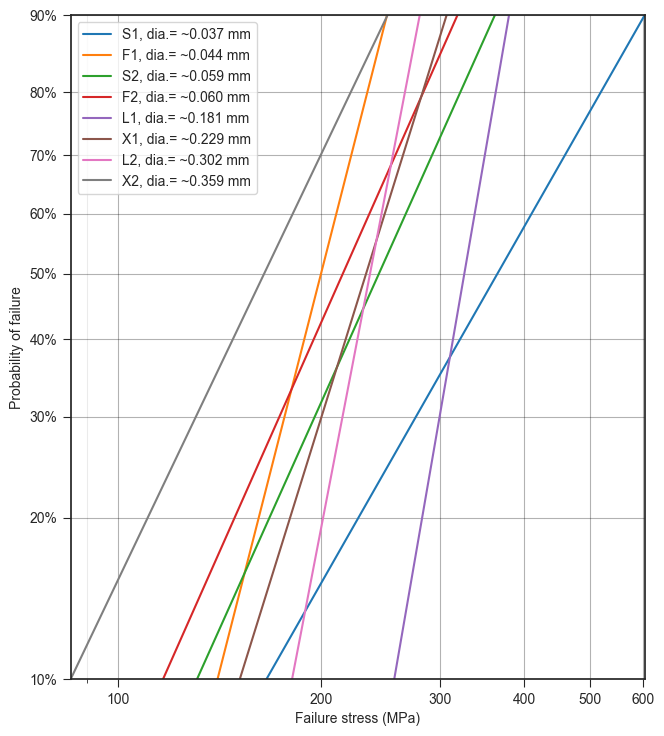

In [579]:
fibre_data, fibre_data_anal = fit_and_plot_weibull(fibre_data, design_prob)

<Figure size 700x800 with 0 Axes>

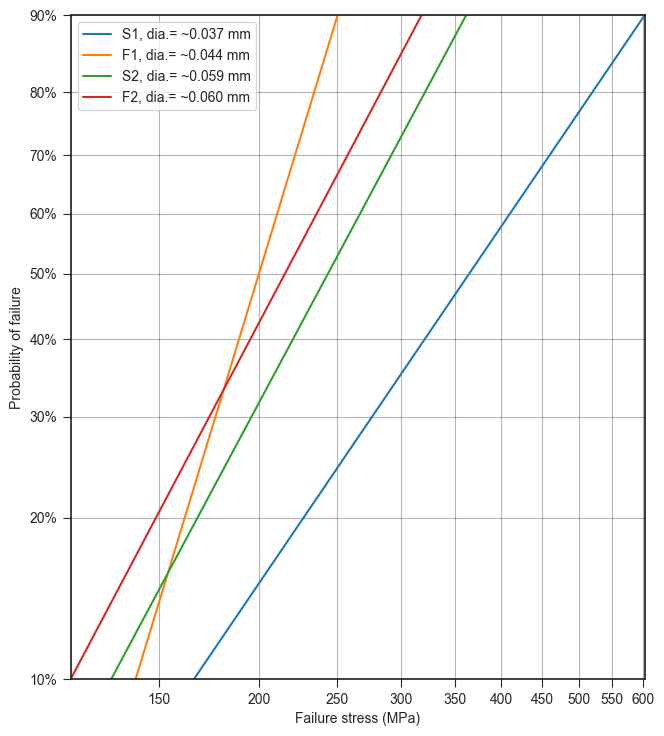

In [580]:
favimat_data, favimat_data_anal = fit_and_plot_weibull(favimat_data, design_prob)

<Figure size 700x800 with 0 Axes>

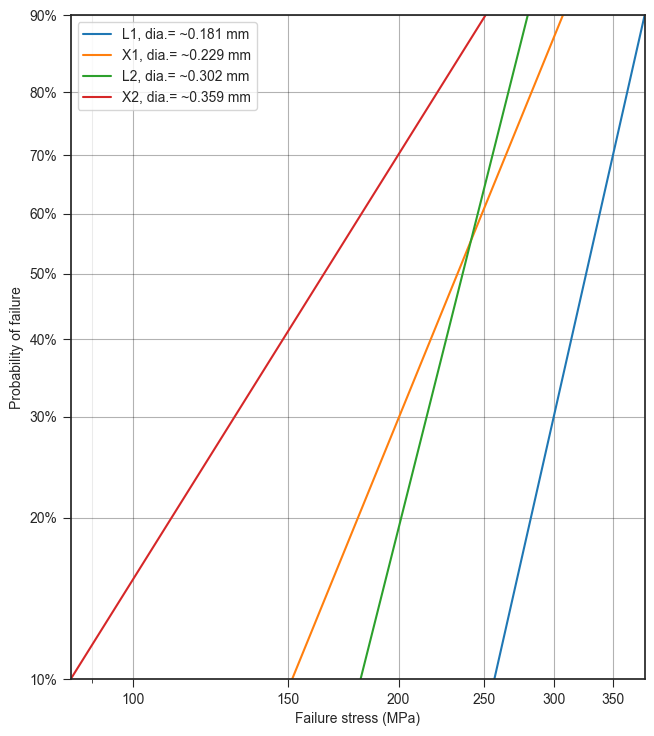

In [581]:
instron_data, instron_data_anal = fit_and_plot_weibull(instron_data, design_prob)

In [582]:
def plot_strength_vs_size(data: pd.DataFrame, g1, g2):
    ### Do a simple plot of mean strength vs surface area

    fig, ax_sa = plt.subplots(sharey=True)
    fig.set_size_inches(8,7)

    unique_series = data["series"].unique()

    leg_points_lines = []

    ## Plot all the fibres
    for series in unique_series:
        plot_data = data[data["series"] == series]
        line = ax_sa.scatter(data=plot_data, x="gage_SA", y="fracture_stress", marker=".", label=series)
        leg_points_lines.append(line)

    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter()) 
    plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())

    eq_fmt = "$\\log(\\sigma) = {:.2f} \\log(A) + {:.2f}$\n$r^2 = {:.2f}$"

    ## fit and plot data on surface area\
    x_g1_data = data.loc[data["series"].isin(g1),"gage_SA"].to_numpy()
    y_g1_data = data.loc[data["series"].isin(g1),"fracture_stress"].to_numpy()

    ## Log-log scale regression
    result = linregress(np.log10(x_g1_data), np.log10(y_g1_data))

    m1, c1 = np.polyfit(np.log10(x_g1_data), np.log10(y_g1_data),1)
    m = result.slope
    c = result.intercept

    x_fit = np.linspace(np.min(x_g1_data), np.max(x_g1_data), 100)
    y_fit = np.power(10, m * np.log10(x_fit) + c)

    reg_line_1, = ax_sa.plot(x_fit, y_fit, "--r", label=eq_fmt.format(m,c,result.rvalue**2))
    print(result.pvalue)

    
    x_g2_data = data.loc[data["series"].isin(g2),"gage_SA"].to_numpy()
    y_g2_data = data.loc[data["series"].isin(g2),"fracture_stress"].to_numpy()

    ## Log-log scale regression
    result = linregress(np.log10(x_g2_data), np.log10(y_g2_data))

    # m, c = np.polyfit(np.log10(x_g2_data), np.log10(y_g2_data),1)
    m = result.slope
    c = result.intercept

    x_fit = np.linspace(np.min(x_g2_data), np.max(x_g2_data), 100)
    y_fit = np.power(10, m * np.log10(x_fit) + c)

    reg_line_2, = ax_sa.plot(x_fit, y_fit, "--b", label=eq_fmt.format(m,c,result.rvalue**2))
    print(result.pvalue)


    ## Plot formatting
    ax_sa.set_xscale("log")
    ax_sa.set_yscale("log")

    ax_sa.grid(visible=True, which='major', linestyle='-')
    ax_sa.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

    ax_sa.set_xlabel(sa_label)
    ax_sa.set_ylabel(stress_label)

    ax_sa.tick_params(which="both", labelleft=True)

    leg_1 = ax_sa.legend(handles=leg_points_lines, ncols=2)
    ax_sa.add_artist(leg_1)

    ax_sa.legend(handles=[reg_line_1, reg_line_2], loc="upper center")

    fig.tight_layout()

8.318899185785063e-05
5.755355809717759e-08


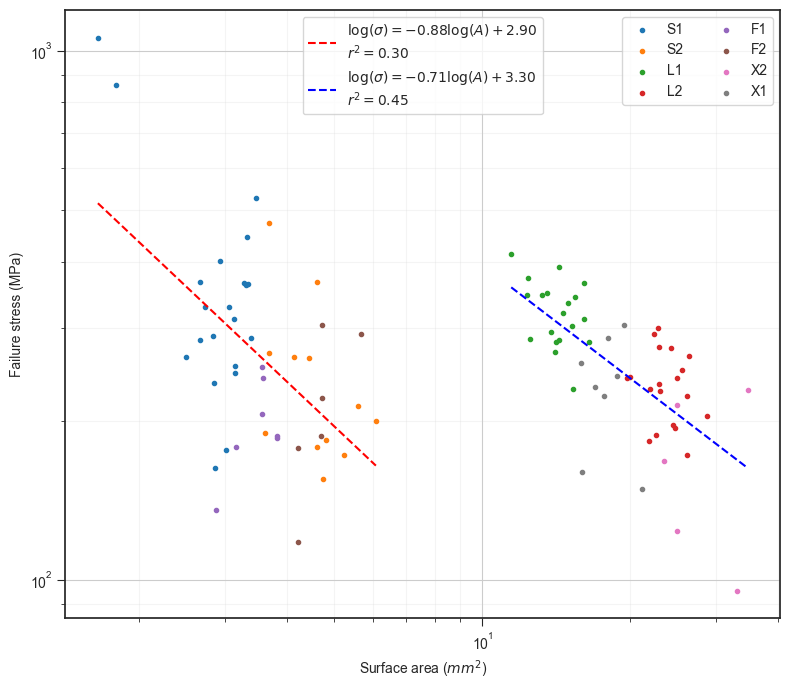

In [583]:
plot_strength_vs_size(fibre_data, g1, g2)

# Heuristic before weibull

Plot LN fracture strength vs LN Volume / surface area. The slope of the graph is -1/m - use this as first guess?

Not sure how to determine weibull strength. Possibly just use the really innacurate linear regression method first, like in the first paper.

In [584]:
def size_effect_normalize(original_prob: float, original_size: float, standard_size: float) -> float:
    ### Normalising formula from sphere compression paper (among other places)
    size_ratio = standard_size / original_size
    return 1 - (1 - original_prob)**size_ratio

In [585]:
def normalize_data(data, v_standard, sa_standard):
    ### Probability normalised to a standard size

    data["Fail Prob V Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["gage_V"], v_standard), axis=1)
    data["Fail Prob SA Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["gage_SA"], sa_standard), axis=1)

    data["standard_gage_v"] = v_standard
    data["standard_gage_sa"] = sa_standard

    return data

In [586]:
fibre_data = normalize_data(fibre_data, standard_v, standard_sa)

instron_data = normalize_data(instron_data, standard_v, standard_sa)

favimat_data = normalize_data(favimat_data, standard_v, standard_sa)

In [587]:
def rough_modulus(sample_data):
    least_squares_data = sample_data[["fracture_stress", "gage_V", "gage_SA"]].dropna()

    stress = least_squares_data["fracture_stress"].to_numpy()
    gage_volume = least_squares_data["gage_V"].to_numpy()

    x = np.log(gage_volume)
    y = np.log(stress)

    result = linregress(x, y)

    modulus = -1/result.slope

    sample_data["rough_modulus_V"] = modulus

    gage_area = least_squares_data["gage_SA"].to_numpy()

    x = np.log(gage_area)
    y = np.log(stress)

    result = linregress(x, y)

    modulus = -1/result.slope

    sample_data["rough_modulus_SA"] = modulus

    return sample_data

In [588]:
fibre_data = rough_modulus(fibre_data)

instron_data = rough_modulus(instron_data)

favimat_data = rough_modulus(favimat_data)

In [589]:
def rough_strength_normalize(sample_data, standard_v, standard_sa):
    v_strength_scale_func = lambda row: row["fracture_stress"] * (row["gage_V"] / standard_v) ** (1/row["rough_modulus_V"])
    sa_strength_scale_func = lambda row: row["fracture_stress"] * (row["gage_SA"] / standard_sa) ** (1/row["rough_modulus_SA"])

    sample_data["rough_scaled_strength_V"] = sample_data.apply(v_strength_scale_func, axis=1)
    sample_data["rough_scaled_strength_SA"] = sample_data.apply(sa_strength_scale_func, axis=1)

    return sample_data

In [590]:
fibre_data = rough_strength_normalize(fibre_data, standard_v, standard_sa)

instron_data = rough_strength_normalize(instron_data, standard_v, standard_sa)

favimat_data = rough_strength_normalize(favimat_data, standard_v, standard_sa)

In [591]:
def fit_normalized_data(data, method):
    ### Use least squares regression to fit a line to the normalised values. Also do the transformations required for weibull parameters
    if method == "V":
        method_column = "Fail Prob V Adj"
    elif method == "SA":
        method_column = "Fail Prob SA Adj"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")
    
    least_squares_data = data[["fracture_stress", method_column]].dropna()

    stress = least_squares_data["fracture_stress"].to_numpy()
    fail_prob = least_squares_data[method_column].to_numpy()

    x = np.log(stress)
    y = np.log(-np.log(1-fail_prob))

    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRX",show_plot=True,label='RRX')
    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRY",show_plot=True,label='RRY')

    result = linregress(x, y)

    beta = result.slope
    alpha = np.exp(-result.intercept / beta)

    return (alpha, beta, result.rvalue)

In [592]:
def fit_strength_normalized_data(data, method):
    ### Use least squares regression to fit a line to the normalised values. Also do the transformations required for weibull parameters
    if method == "V":
        method_column = "rough_scaled_strength_V"
    elif method == "SA":
        method_column = "rough_scaled_strength_SA"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")
    
    least_squares_data = data[[method_column, "Fail Prob"]].dropna()

    stress = least_squares_data[method_column].to_numpy()
    fail_prob = least_squares_data["Fail Prob"].to_numpy()

    x = np.log(stress)
    y = np.log(-np.log(1-fail_prob))

    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRX",show_plot=True,label='RRX')
    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRY",show_plot=True,label='RRY')

    result = linregress(x, y)

    beta = result.slope
    alpha = np.exp(-result.intercept / beta)

    return (alpha, beta, result.rvalue)

In [593]:
def plot_normalized_weibull(data, analysed_data):
    ### Make a big fancy figure of normalised data with colour coded sample series
    normalise_unique_series = analysed_data.dropna().index.unique()

    spacing = 0.05

    ## Work out limits for scaling
    x_max = np.log10(data["fracture_stress"].max())
    x_min = np.log10(data["fracture_stress"].min())

    x_range = x_max - x_min
    
    xlims = [10 **(x_min - x_range * spacing),
             10 **(x_max + x_range * spacing)]
    
    ## For volume
    y_max = axes_transforms.weibull_forward(data["Fail Prob V Adj"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob V Adj"].min())

    y_range = y_max - y_min
    
    v_ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
               axes_transforms.weibull_inverse(y_max + y_range * spacing)]
    
    y_max = axes_transforms.weibull_forward(data["Fail Prob SA Adj"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob SA Adj"].min())

    y_range = y_max - y_min
    
    sa_ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
                axes_transforms.weibull_inverse(y_max + y_range * spacing)]

    ##  Get parameters required to generate weibull distributions
    v_alpha, v_beta, v_r = fit_normalized_data(data, "V")
    sa_alpha, sa_beta, sa_r = fit_normalized_data(data, "SA")

    ## Make distributions according to parameters
    v_dist = Weibull_Distribution(alpha=v_alpha, beta=v_beta)
    sa_dist = Weibull_Distribution(alpha=sa_alpha, beta=sa_beta)
    
    ## Get values for plotting the distribution line
    v_dist_x = np.linspace(xlims[0], xlims[1], 200)
    v_dist_y = v_dist.CDF(xvals=v_dist_x, show_plot=False)

    sa_dist_x = np.linspace(xlims[0], xlims[1], 200)
    sa_dist_y = sa_dist.CDF(xvals=sa_dist_x, show_plot=False)

    ## Plot the distribution lines
    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained")

    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$, $r^2 = {:.2f}$"

    ax_v.plot(v_dist_x, v_dist_y, "--r", label=fit_label_fmt.format("Volume", v_alpha, v_beta, v_r**2))
    ax_sa.plot(sa_dist_x, sa_dist_y, "--r", label=fit_label_fmt.format("Surface area", sa_alpha, sa_beta, sa_r**2))

    ## Put a scatter plot of each series on the figure, with nice colour and marker coding
    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]

        marker_symb = next(marker_cycler)
        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)

        ax_v.scatter(data=plot_data, x="fracture_stress", y="Fail Prob V Adj", label=legend_text, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="fracture_stress", y="Fail Prob SA Adj", label=legend_text, marker=marker_symb)

    ## Use some funky functions from the reliability library to scale the weibull distribution to a straight line
    ax_v.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_v.set_xscale("log")

    ax_sa.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_sa.set_xscale("log")

    ## Using reliability library functions to format the axes correctly
    plt.sca(ax_v)
    ax_v.set_xlim(xlims)
    ax_v.set_ylim(v_ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    plt.sca(ax_sa)
    ax_sa.set_xlim(xlims)
    ax_sa.set_ylim(sa_ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    ## Labelling and formatting
    ax_v.set_xlabel(stress_label)
    ax_v.set_ylabel("Probability of failure")

    ax_sa.set_xlabel(stress_label)
    ax_sa.set_ylabel("Probability of failure")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(12, 9)

    print("Volume rsquared = ", v_r**2)
    print("Standard volume = ", data["standard_gage_v"].iloc[0], '\n')

    print("Surface area rsquared = ", sa_r**2)
    print("Standard surface area = ", data["standard_gage_sa"].iloc[0])

    return v_dist, sa_dist

In [594]:
def plot_rough_normalized_weibull(data, analysed_data):
    ### Make a big fancy figure of normalised data with colour coded sample series
    normalise_unique_series = analysed_data.dropna().index.unique()

    spacing = 0.05

    ## Work out limits for scaling
    x_max = np.log10(data["rough_scaled_strength_V"].max())
    x_min = np.log10(data["rough_scaled_strength_V"].min())

    x_range = x_max - x_min
    
    v_xlims = [10 **(x_min - x_range * spacing),
               10 **(x_max + x_range * spacing)]
    
    x_max = np.log10(data["rough_scaled_strength_SA"].max())
    x_min = np.log10(data["rough_scaled_strength_SA"].min())

    x_range = x_max - x_min
    
    sa_xlims = [10 **(x_min - x_range * spacing),
                10 **(x_max + x_range * spacing)]
    
    ## For volume
    y_max = axes_transforms.weibull_forward(data["Fail Prob"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob"].min())

    y_range = y_max - y_min
    
    ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
               axes_transforms.weibull_inverse(y_max + y_range * spacing)]
    

    ##  Get parameters required to generate weibull distributions
    v_alpha, v_beta, v_r = fit_strength_normalized_data(data, "V")
    sa_alpha, sa_beta, sa_r = fit_strength_normalized_data(data, "SA")

    ## Make distributions according to parameters
    v_dist = Weibull_Distribution(alpha=v_alpha, beta=v_beta)
    sa_dist = Weibull_Distribution(alpha=sa_alpha, beta=sa_beta)
    
    ## Get values for plotting the distribution line
    v_dist_x = np.linspace(v_xlims[0], v_xlims[1], 200)
    v_dist_y = v_dist.CDF(xvals=v_dist_x, show_plot=False)

    sa_dist_x = np.linspace(sa_xlims[0], sa_xlims[1], 200)
    sa_dist_y = sa_dist.CDF(xvals=sa_dist_x, show_plot=False)

    ## Plot the distribution lines
    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained")

    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$, $r^2 = {:.2f}$"

    ax_v.plot(v_dist_x, v_dist_y, "--r", label=fit_label_fmt.format("Volume", v_alpha, v_beta, v_r**2))
    ax_sa.plot(sa_dist_x, sa_dist_y, "--r", label=fit_label_fmt.format("Surface area", sa_alpha, sa_beta, sa_r**2))

    ## Put a scatter plot of each series on the figure, with nice colour and marker coding
    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]

        marker_symb = next(marker_cycler)
        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)

        ax_v.scatter(data=plot_data, x="rough_scaled_strength_V", y="Fail Prob", label=legend_text, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="rough_scaled_strength_SA", y="Fail Prob", label=legend_text, marker=marker_symb)

    ## Use some funky functions from the reliability library to scale the weibull distribution to a straight line
    ax_v.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_v.set_xscale("log")

    ax_sa.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_sa.set_xscale("log")

    ## Using reliability library functions to format the axes correctly
    plt.sca(ax_v)
    ax_v.set_xlim(v_xlims)
    ax_v.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    plt.sca(ax_sa)
    ax_sa.set_xlim(sa_xlims)
    ax_sa.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    ## Labelling and formatting
    ax_v.set_xlabel(stress_label)
    ax_v.set_ylabel("Probability of failure")

    ax_sa.set_xlabel(stress_label)
    ax_sa.set_ylabel("Probability of failure")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(12, 9)

    print("Volume rsquared = ", v_r**2)
    print("Standard volume = ", data["standard_gage_v"].iloc[0], '\n')

    print("Surface area rsquared = ", sa_r**2)
    print("Standard surface area = ", data["standard_gage_sa"].iloc[0])

    return v_dist, sa_dist

Volume rsquared =  0.46244230478462645
Standard volume =  19.634954084936208 

Surface area rsquared =  0.46244230478462645
Standard surface area =  78.53981633974483


<Figure size 640x480 with 0 Axes>

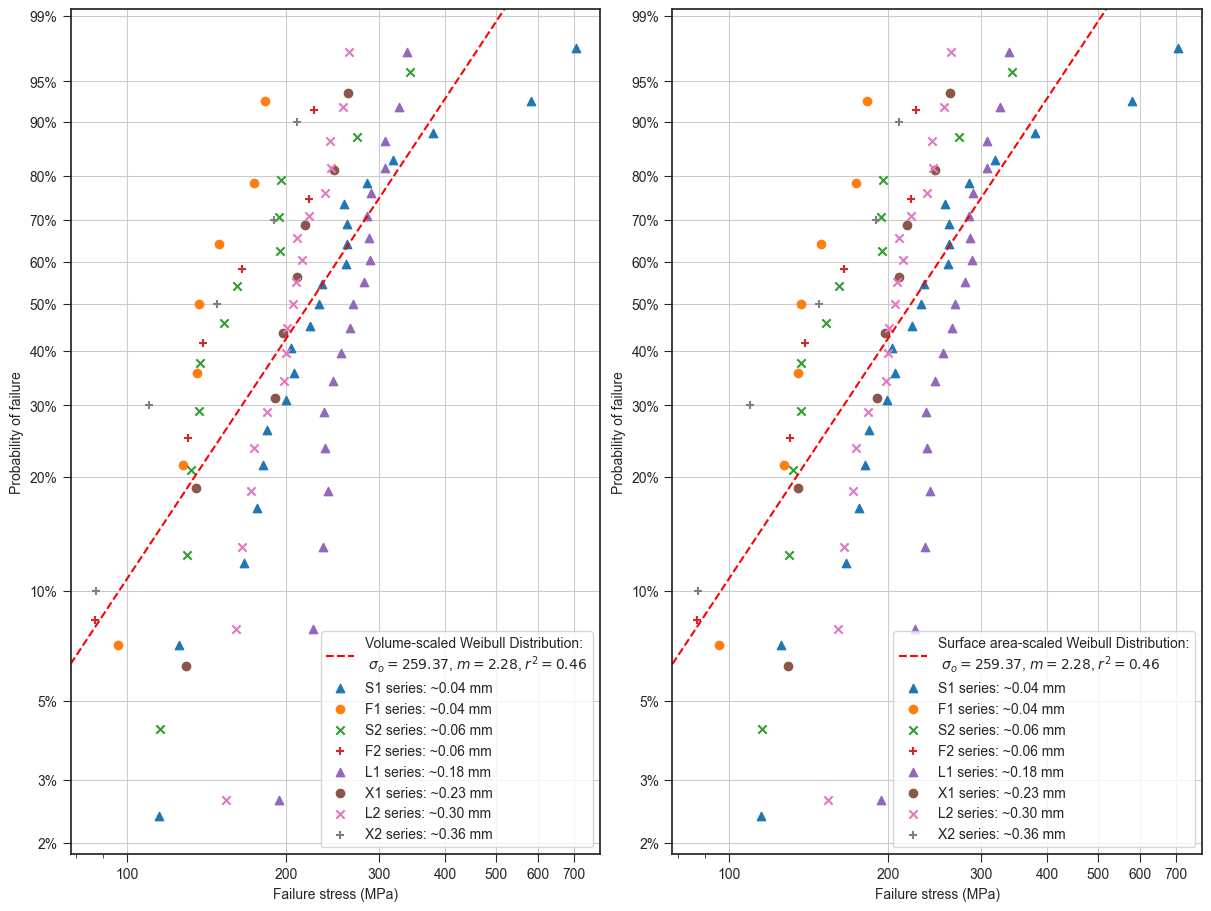

In [595]:
v_dist, sa_dist = plot_rough_normalized_weibull(fibre_data, fibre_data_anal)

Volume rsquared =  0.5304034117049025
Standard volume =  19.634954084936208 

Surface area rsquared =  0.5304034117049028
Standard surface area =  78.53981633974483


<Figure size 640x480 with 0 Axes>

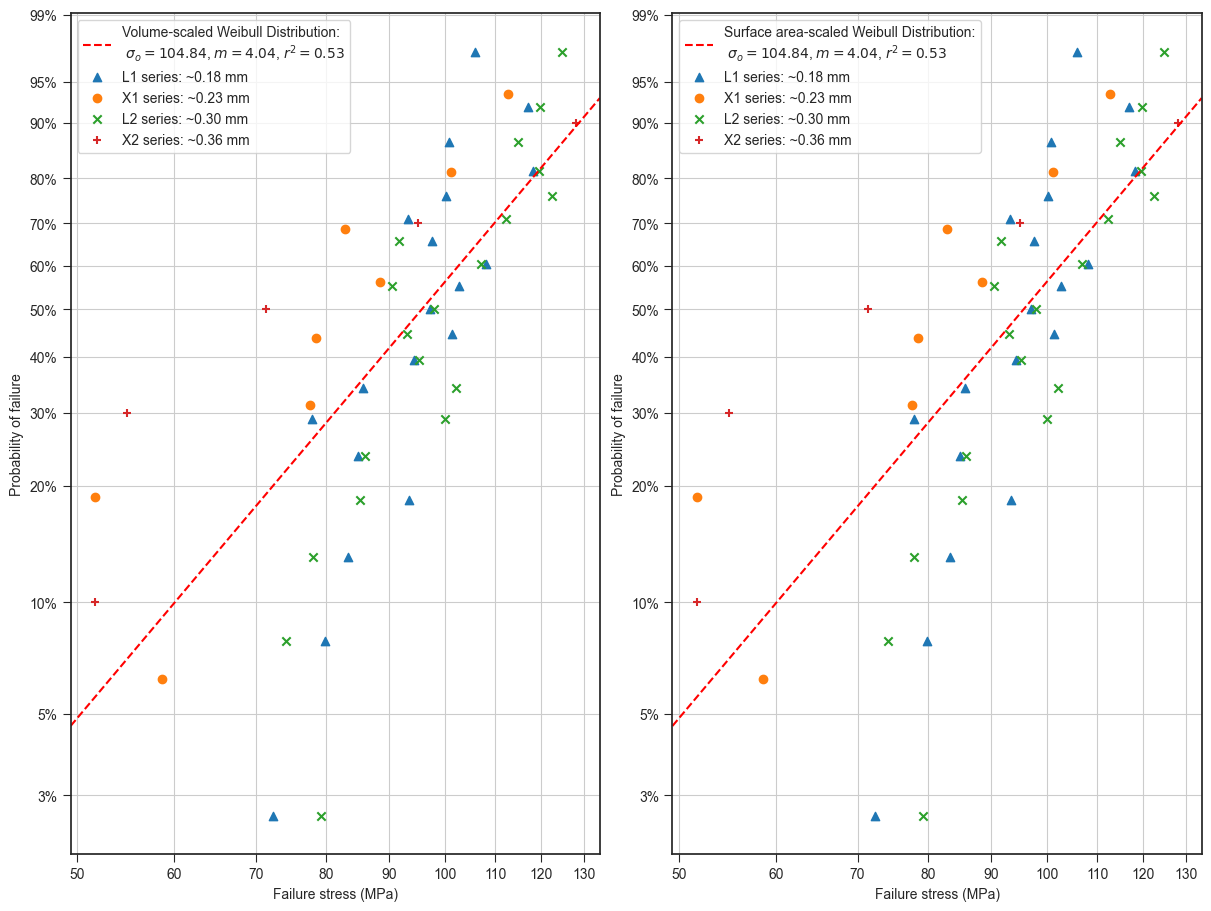

In [596]:
instron_v_dist, instron_v_sa_dist = plot_rough_normalized_weibull(instron_data, instron_data_anal)

Volume rsquared =  0.7024732734305086
Standard volume =  19.634954084936208 

Surface area rsquared =  0.7024732734305089
Standard surface area =  78.53981633974483


<Figure size 640x480 with 0 Axes>

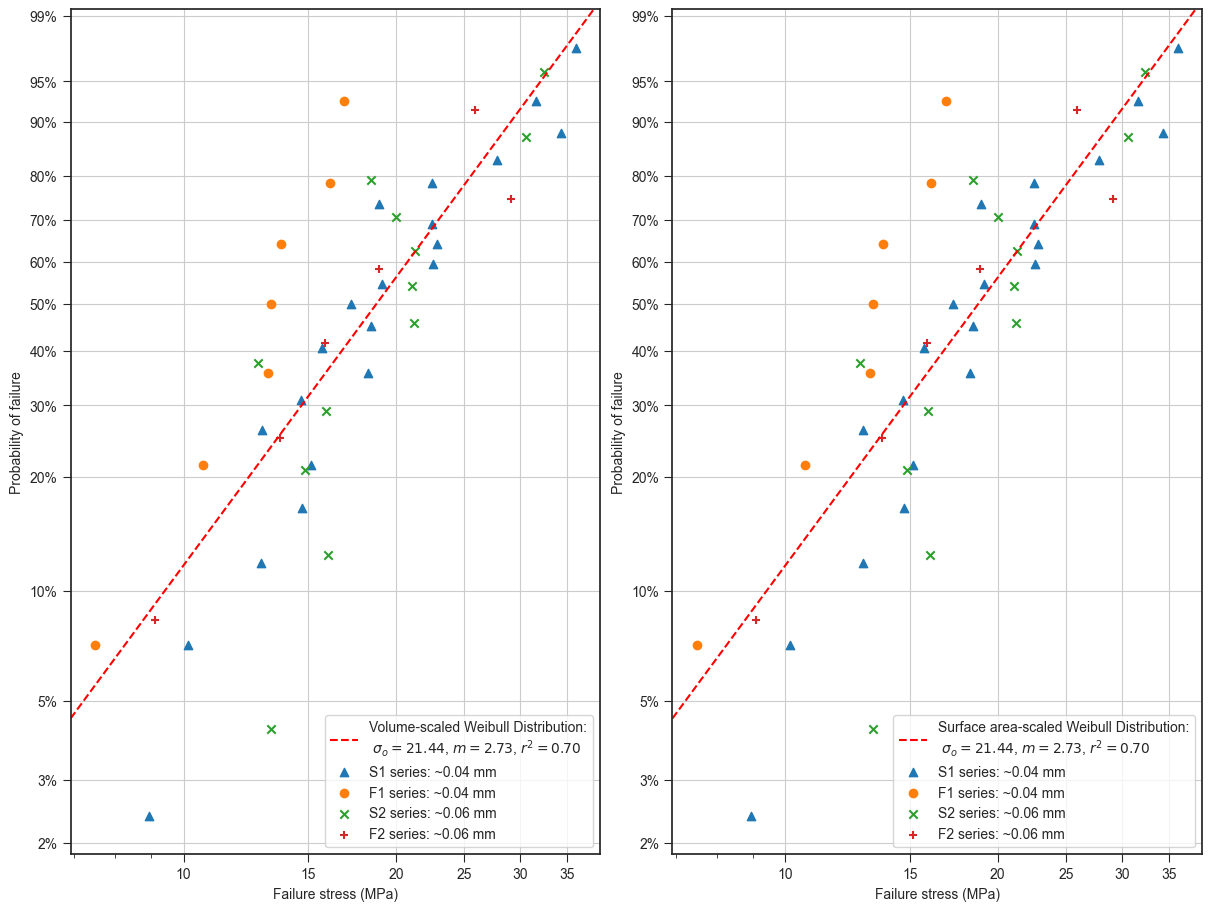

In [597]:
favimat_v_dist, favimat_v_sa_dist = plot_rough_normalized_weibull(favimat_data, favimat_data_anal)

# Weibull size scaling

Using likelihood optimisation method, taking a first guess from the previous section

In [598]:
def scaled_log_likelihood(weib_params, data, size_method):
    ## Returns a function of the size scaled maximum liklihood. Used for scipy.optimize.minimize
    if size_method == "V":
        size_label = "gage_V"
        standard_size_label = "standard_gage_v"
    elif size_method == "SA":
        size_label = "gage_SA"
        standard_size_label = "standard_gage_sa"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")

    weib_sigma = weib_params[0]
    weib_mod = weib_params[1]

    standard_size = data[standard_size_label].iloc[0]

    n = 0

    sum_volumes = 0
    sum_strength = 0
    sum_exponential = 0

    for row in data.itertuples():
        volume_term = getattr(row, size_label) / standard_size
        frac_stress = row.fracture_stress

        sum_volumes += np.log(volume_term)
        sum_strength += np.log(frac_stress)
        sum_exponential += volume_term * (frac_stress / weib_sigma)**weib_mod

        n += 1

    sum_strength *= (weib_mod - 1)

    n_ln_m = n * np.log(weib_mod)

    n_m_ln_sigma = n * weib_mod * np.log(weib_sigma)
    
    return n_ln_m - n_m_ln_sigma + sum_volumes + sum_strength - sum_exponential

In [599]:
def minimize_log_likelihood(data, v_dist, sa_dist):
    likelihood_function_v = lambda x: -scaled_log_likelihood(x, data, "V")
    likelihood_function_sa = lambda x: -scaled_log_likelihood(x, data, "SA")
    weib_bounds = [(0, None),
                   (0, None)]
    
    v_guess = [v_dist.alpha, v_dist.beta]
    sa_guess = [sa_dist.alpha, sa_dist.beta]

    result_v = minimize(likelihood_function_v, v_guess, bounds=weib_bounds)
    result_sa = minimize(likelihood_function_sa, sa_guess, bounds=weib_bounds)

    print("Optimisation on volume:")
    print(result_v, "\n")

    print("Optimisation on surface area:")
    print(result_sa)

    sample_size = len(data.index)
    
    return weib_params(sigma=result_v.x[0], mod=result_v.x[1], sample_size=sample_size), weib_params(sigma=result_sa.x[0], mod=result_sa.x[1], sample_size=sample_size)

In [600]:
drop_cols = ["char_strength",
             "weibull_modulus"]

fibre_data = fibre_data.drop(drop_cols, axis=1)

In [601]:
weib_params_v, weib_params_sa = minimize_log_likelihood(fibre_data, v_dist, sa_dist)

Optimisation on volume:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 619.3740202189048
        x: [ 1.247e+02  4.335e+00]
      nit: 16
      jac: [-2.274e-05  7.731e-04]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64> 

Optimisation on surface area:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 586.1895062452454
        x: [ 1.550e+02  3.134e+00]
      nit: 17
      jac: [ 2.274e-05 -8.185e-04]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [602]:
instron_weib_params_v, instron_weib_params_sa = minimize_log_likelihood(instron_data, instron_v_dist, instron_v_sa_dist)

Optimisation on volume:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 273.32403315839156
        x: [ 1.592e+02  5.214e+00]
      nit: 20
      jac: [-5.684e-06  5.116e-05]
     nfev: 66
     njev: 22
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64> 

Optimisation on surface area:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 279.05514297009614
        x: [ 2.053e+02  4.696e+00]
      nit: 20
      jac: [ 5.684e-06 -3.411e-05]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [603]:
favimat_weib_params_v, favimat_weib_params_sa = minimize_log_likelihood(favimat_data, favimat_v_dist, favimat_v_sa_dist)

Optimisation on volume:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 278.9679091730354
        x: [ 2.780e+01  2.563e+00]
      nit: 15
      jac: [ 0.000e+00 -2.217e-04]
     nfev: 51
     njev: 17
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64> 

Optimisation on surface area:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 284.37828136630156
        x: [ 7.785e+01  2.211e+00]
      nit: 19
      jac: [-1.705e-05  2.672e-04]
     nfev: 63
     njev: 21
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


## Classic pooled Weibull plot

In [604]:
def plot_normalized_weibull_stage_2(data, analysed_data, v_weib_params, sa_weib_params):
    ### Make a big fancy figure of normalised data with colour coded sample series
    normalise_unique_series = analysed_data.dropna().index.unique()

    spacing = 0.05

    ## Work out limits for scaling
    x_max = np.log10(data["fracture_stress"].max())
    x_min = np.log10(data["fracture_stress"].min())

    x_range = x_max - x_min
    
    xlims = [10 **(x_min - x_range * spacing),
             10 **(x_max + x_range * spacing)]
    
    ## For volume
    y_max = axes_transforms.weibull_forward(data["Fail Prob V Adj"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob V Adj"].min())

    y_range = y_max - y_min
    
    v_ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
               axes_transforms.weibull_inverse(y_max + y_range * spacing)]
    
    y_max = axes_transforms.weibull_forward(data["Fail Prob SA Adj"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob SA Adj"].min())

    y_range = y_max - y_min
    
    sa_ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
                axes_transforms.weibull_inverse(y_max + y_range * spacing)]
    
    ylims = [np.max([np.min([v_ylims[0], sa_ylims[0]]), 1e-10]),
             np.min([np.max([v_ylims[1], sa_ylims[1]]), 1-9e-17])]

    ## Make distributions according to parameters
    v_dist = Weibull_Distribution(alpha=v_weib_params.sigma, beta=v_weib_params.mod)
    sa_dist = Weibull_Distribution(alpha=sa_weib_params.sigma, beta=sa_weib_params.mod)
    
    ## Get values for plotting the distribution line
    v_dist_x = np.linspace(xlims[0], xlims[1], 200)
    v_dist_y = v_dist.CDF(xvals=v_dist_x, show_plot=False)

    sa_dist_x = np.linspace(xlims[0], xlims[1], 200)
    sa_dist_y = sa_dist.CDF(xvals=sa_dist_x, show_plot=False)

    ## Plot the distribution lines
    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained")

    v_y_true = []
    v_y_pred = []

    sa_y_true = []
    sa_y_pred = []

    ## Put a scatter plot of each series on the figure, with nice colour and marker coding
    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]

        marker_symb = next(marker_cycler)
        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)

        ax_v.scatter(data=plot_data, x="fracture_stress", y="Fail Prob V Adj", label=legend_text, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="fracture_stress", y="Fail Prob SA Adj", label=legend_text, marker=marker_symb)

        v_y_true.extend(plot_data["Fail Prob V Adj"].tolist())
        v_y_pred.extend(v_dist.CDF(xvals=plot_data["fracture_stress"].tolist(), show_plot=False))

        sa_y_true.extend(plot_data["Fail Prob SA Adj"].tolist())
        sa_y_pred.extend(sa_dist.CDF(xvals=plot_data["fracture_stress"].tolist(), show_plot=False))

    v_r2 = r2_score(v_y_true, v_y_pred)
    sa_r2 = r2_score(sa_y_true, sa_y_pred)

    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$, $r^2 = {:.2f}$"

    ax_v.plot(v_dist_x, v_dist_y, "--r", label=fit_label_fmt.format("Volume", v_weib_params.sigma, v_weib_params.mod, v_r2))
    ax_sa.plot(sa_dist_x, sa_dist_y, "--r", label=fit_label_fmt.format("Surface area", sa_weib_params.sigma, sa_weib_params.mod, sa_r2))


    ## Use some funky functions from the reliability library to scale the weibull distribution to a straight line
    ax_v.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_v.set_xscale("log")

    ax_sa.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_sa.set_xscale("log")

    ## Using reliability library functions to format the axes correctly
    plt.sca(ax_v)
    ax_v.set_xlim(xlims)
    ax_v.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")
    # plt.xlim(plt.ylim([0.01, 0.99999]))

    plt.sca(ax_sa)
    ax_sa.set_xlim(xlims)
    ax_sa.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    ## Labelling and formatting
    ax_v.set_xlabel(stress_label)
    ax_v.set_ylabel("Probability of failure")

    ax_sa.set_xlabel(stress_label)
    ax_sa.set_ylabel("Probability of failure")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(14,7)

    print("MLE scaling method:", "\n")
    
    print("Scaled on volume:")
    print("Standard volume = ", data["standard_gage_v"].iloc[0])
    print("Weibull Scale = ", v_weib_params.sigma)
    print("Weibull Modulus = ", v_weib_params.mod, "\n")

    print("Scaled on surface area:")
    print("Standard surface area = ", data["standard_gage_sa"].iloc[0])
    print("Weibull Scale = ", sa_weib_params.sigma)
    print("Weibull Modulus = ", sa_weib_params.mod)

    return v_dist, sa_dist

MLE scaling method: 

Scaled on volume:
Standard volume =  19.634954084936208
Weibull Scale =  124.66714200467894
Weibull Modulus =  4.335210346549387 

Scaled on surface area:
Standard surface area =  78.53981633974483
Weibull Scale =  155.0281134147335
Weibull Modulus =  3.134197405623049


<Figure size 640x480 with 0 Axes>

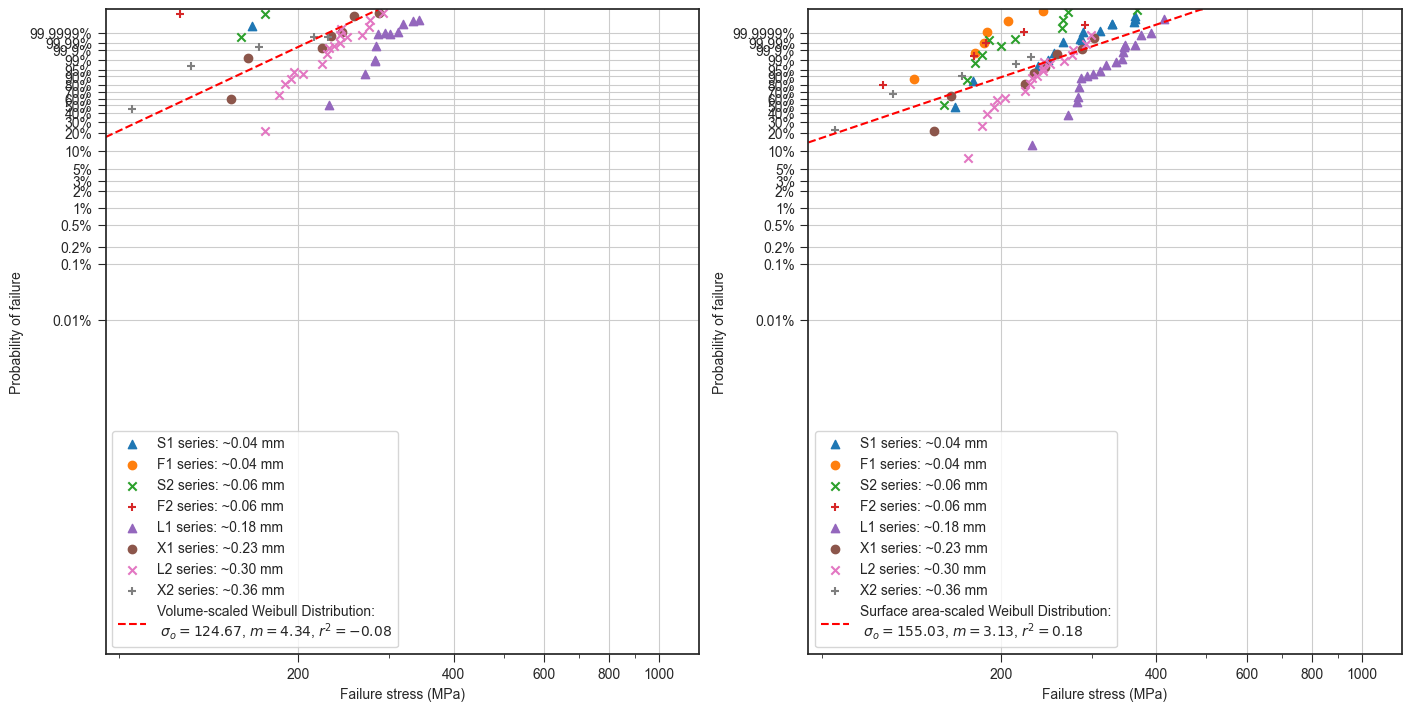

In [605]:
v_dist, sa_dist = plot_normalized_weibull_stage_2(fibre_data, fibre_data_anal, weib_params_v, weib_params_sa)

## Strength normalised weibull plot

In [606]:
def strength_normalize(sample_data, v_weib_params, sa_weib_params, standard_v, standard_sa):
    v_strength_scale_func = lambda row: row["fracture_stress"] * (row["gage_V"] / standard_v) ** (1/v_weib_params.mod)
    sa_strength_scale_func = lambda row: row["fracture_stress"] * (row["gage_SA"] / standard_sa) ** (1/sa_weib_params.mod)

    sample_data["scaled_strength_V"] = sample_data.apply(v_strength_scale_func, axis=1)
    sample_data["scaled_strength_SA"] = sample_data.apply(sa_strength_scale_func, axis=1)

    return sample_data

In [607]:
def plot_strength_normalized_weibull(data, analysed_data, v_weib_params, sa_weib_params):
    ### Make a big fancy figure of normalised data with colour coded sample series
    normalise_unique_series = analysed_data.dropna().index.unique()

    spacing = 0.05

    ## Work out limits for scaling
    ## Volume x:
    x_max = np.log10(data["scaled_strength_V"].max())
    x_min = np.log10(data["scaled_strength_V"].min())

    x_range = x_max - x_min
    
    v_xlims = [10 **(x_min - x_range * spacing),
               10 **(x_max + x_range * spacing)]
    
    ## Surface area x
    x_max = np.log10(data["scaled_strength_SA"].max())
    x_min = np.log10(data["scaled_strength_SA"].min())

    x_range = x_max - x_min
    
    sa_xlims = [10 **(x_min - x_range * spacing),
               10 **(x_max + x_range * spacing)]

    # ## For volume
    y_max = axes_transforms.weibull_forward(data["Fail Prob"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob"].min())

    y_range = y_max - y_min
    
    ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
             axes_transforms.weibull_inverse(y_max + y_range * spacing)]

    ## Make distributions according to parameters
    v_dist = Weibull_Distribution(alpha=v_weib_params.sigma, beta=v_weib_params.mod)
    sa_dist = Weibull_Distribution(alpha=sa_weib_params.sigma, beta=sa_weib_params.mod)
    
    ## Get values for plotting the distribution line
    v_dist_x = np.linspace(v_xlims[0], v_xlims[1], 200)
    v_dist_y = v_dist.CDF(xvals=v_dist_x, show_plot=False)

    sa_dist_x = np.linspace(sa_xlims[0], sa_xlims[1], 200)
    sa_dist_y = sa_dist.CDF(xvals=sa_dist_x, show_plot=False)

    ## Plot the distribution lines
    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained")

    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$, $r^2 = {:.2f}$"

    v_x_true = []
    v_x_pred = []

    sa_x_true = []
    sa_x_pred = []

    ## Put a scatter plot of each series on the figure, with nice colour and marker coding
    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]

        marker_symb = next(marker_cycler)
        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.3f mm" % (letter, avg_diameter)

        ax_v.scatter(data=plot_data, x="scaled_strength_V", y="Fail Prob", label=legend_text, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="scaled_strength_SA", y="Fail Prob", label=legend_text, marker=marker_symb)

        v_x_true.extend(plot_data["scaled_strength_V"].tolist())
        v_x_pred.extend(v_dist.quantile(q=plot_data["Fail Prob"].tolist()))

        sa_x_true.extend(plot_data["scaled_strength_SA"].tolist())
        sa_x_pred.extend(sa_dist.quantile(q=plot_data["Fail Prob"].tolist()))

    v_r2 = r2_score(v_x_true, v_x_pred)
    sa_r2 = r2_score(sa_x_true, sa_x_pred)

    ax_v.plot(v_dist_x, v_dist_y, "--r", label=fit_label_fmt.format("Volume", v_weib_params.sigma, v_weib_params.mod, v_r2))
    ax_sa.plot(sa_dist_x, sa_dist_y, "--r", label=fit_label_fmt.format("Surface area", sa_weib_params.sigma, sa_weib_params.mod, sa_r2))

    ## Use some funky functions from the reliability library to scale the weibull distribution to a straight line
    ax_v.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_v.set_xscale("log")

    ax_sa.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_sa.set_xscale("log")

    ## Using reliability library functions to format the axes correctly
    plt.sca(ax_v)
    ax_v.set_xlim(v_xlims)
    ax_v.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")
    # plt.xlim(plt.ylim([0.01, 0.99999]))

    plt.sca(ax_sa)
    ax_sa.set_xlim(sa_xlims)
    ax_sa.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    ## Labelling and formatting
    ax_v.set_xlabel(stress_label)
    ax_v.set_ylabel("Probability of failure")

    ax_sa.set_xlabel(stress_label)
    ax_sa.set_ylabel("Probability of failure")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(15, 7.5)

    print("MLE scaling method:", "\n")
    
    print("Scaled on volume:")
    print("Standard volume = ", data["standard_gage_v"].iloc[0])
    print("Weibull Scale = ", v_weib_params.sigma)
    print("Weibull Modulus = ", v_weib_params.mod, "\n")

    print("Scaled on surface area:")
    print("Standard surface area = ", data["standard_gage_sa"].iloc[0])
    print("Weibull Scale = ", sa_weib_params.sigma)
    print("Weibull Modulus = ", sa_weib_params.mod)

    return v_dist, sa_dist

In [608]:
fibre_data = strength_normalize(fibre_data, weib_params_v, weib_params_sa, standard_v, standard_sa)

instron_data = strength_normalize(instron_data, instron_weib_params_v, instron_weib_params_sa, standard_v, standard_sa)

favimat_data = strength_normalize(favimat_data, favimat_weib_params_v, favimat_weib_params_sa, standard_v, standard_sa)

MLE scaling method: 

Scaled on volume:
Standard volume =  19.634954084936208
Weibull Scale =  124.66714200467894
Weibull Modulus =  4.335210346549387 

Scaled on surface area:
Standard surface area =  78.53981633974483
Weibull Scale =  155.0281134147335
Weibull Modulus =  3.134197405623049


<Figure size 640x480 with 0 Axes>

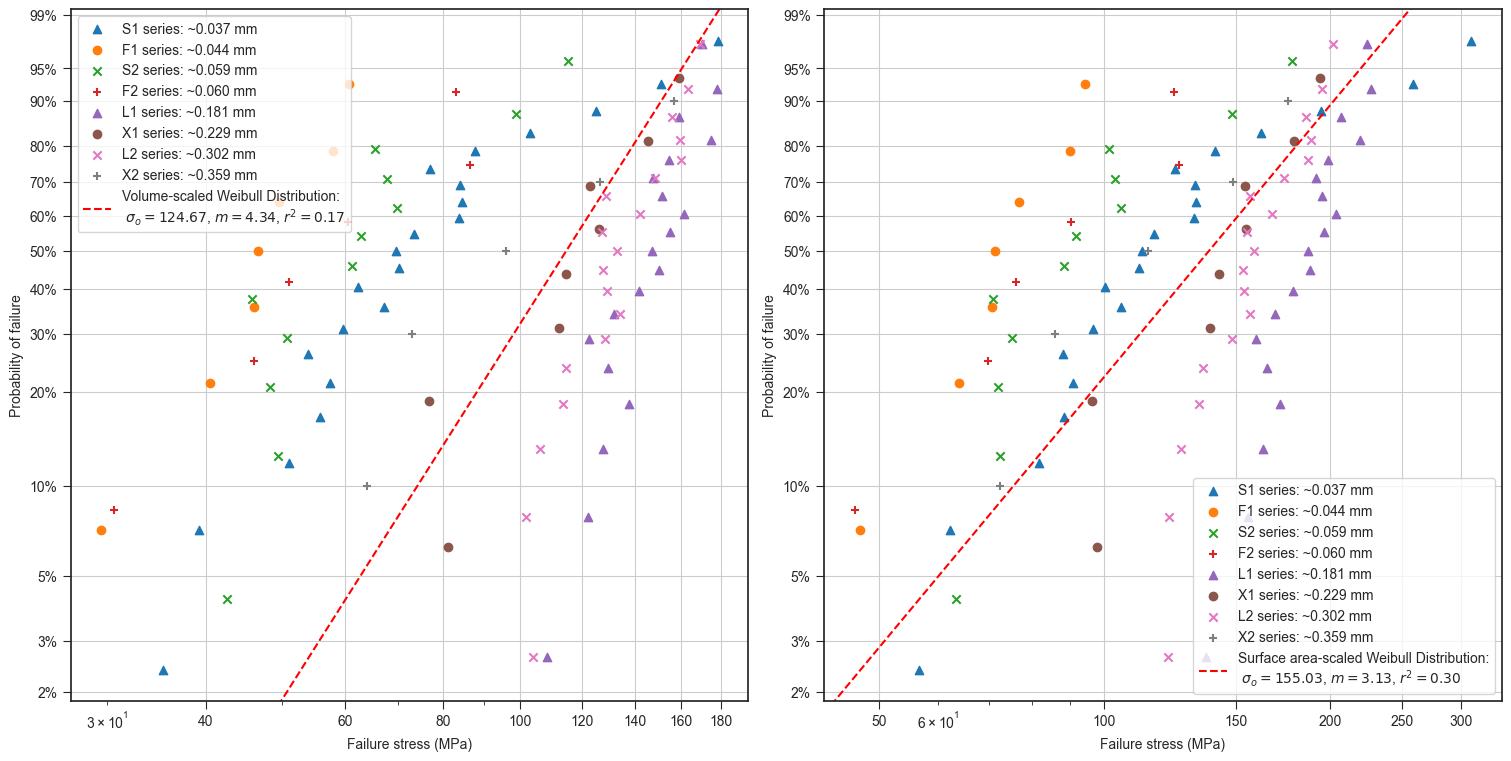

In [609]:
v_dist, sa_dist = plot_strength_normalized_weibull(fibre_data, fibre_data_anal, weib_params_v, weib_params_sa)

MLE scaling method: 

Scaled on volume:
Standard volume =  19.634954084936208
Weibull Scale =  27.796805562455717
Weibull Modulus =  2.5627259485805944 

Scaled on surface area:
Standard surface area =  78.53981633974483
Weibull Scale =  77.8487434213087
Weibull Modulus =  2.210735788554358


(<reliability.Distributions.Weibull_Distribution at 0x265d41a1940>,
 <reliability.Distributions.Weibull_Distribution at 0x265d41a15b0>)

<Figure size 640x480 with 0 Axes>

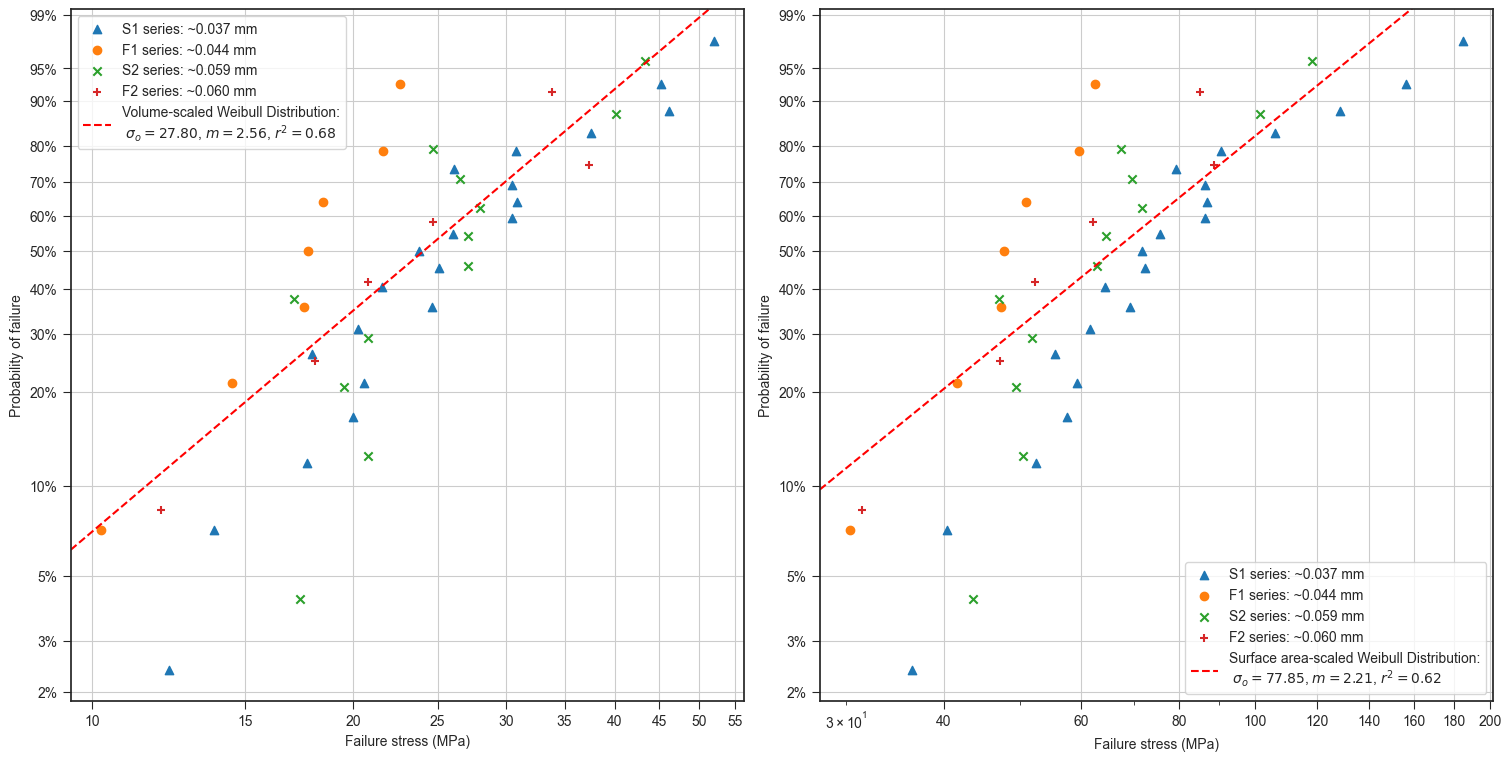

In [610]:
plot_strength_normalized_weibull(favimat_data, favimat_data_anal, favimat_weib_params_v, favimat_weib_params_sa)

MLE scaling method: 

Scaled on volume:
Standard volume =  19.634954084936208
Weibull Scale =  159.20371152703973
Weibull Modulus =  5.214153103006061 

Scaled on surface area:
Standard surface area =  78.53981633974483
Weibull Scale =  205.2529369396619
Weibull Modulus =  4.696028408503979


(<reliability.Distributions.Weibull_Distribution at 0x265d41a3230>,
 <reliability.Distributions.Weibull_Distribution at 0x265cbf66c40>)

<Figure size 640x480 with 0 Axes>

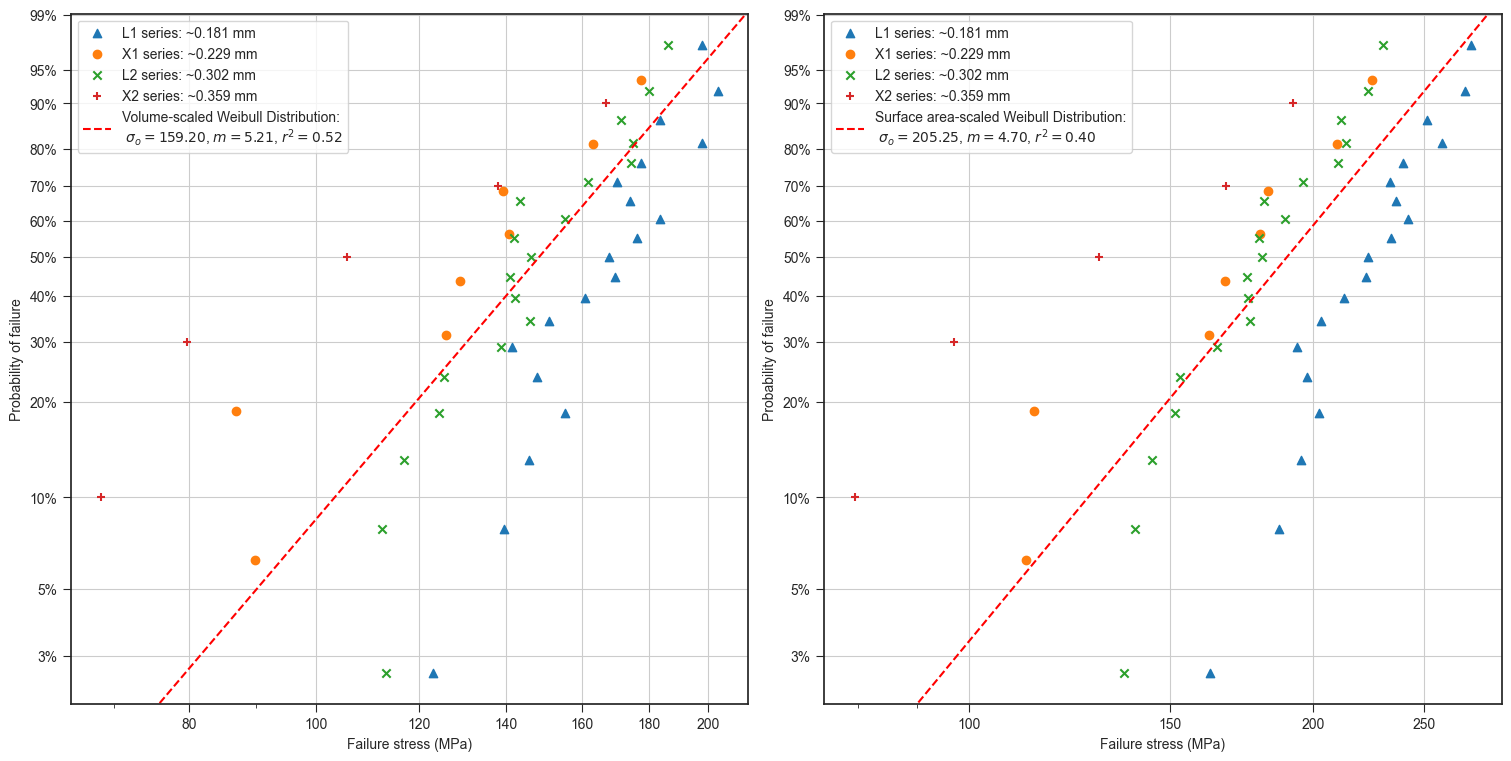

In [611]:
plot_strength_normalized_weibull(instron_data, instron_data_anal, instron_weib_params_v, instron_weib_params_sa)

## Size normalised plots

In [612]:
def normalise_size(data, arbitrary_prob):
    normalise_helper_V = lambda row: (np.log(1-arbitrary_prob) / np.log(1-row["Fail Prob"])) * row["gage_V"]
    normalise_helper_SA = lambda row: (np.log(1-arbitrary_prob) / np.log(1-row["Fail Prob"])) * row["gage_SA"]

    data["norm_V"] = data.apply(normalise_helper_V, axis=1)
    data["norm_SA"] = data.apply(normalise_helper_SA, axis=1)

    return data

In [613]:
fibre_data = normalise_size(fibre_data, arbitrary_prob)
favimat_data = normalise_size(favimat_data, arbitrary_prob)
instron_data = normalise_size(instron_data, arbitrary_prob)

In [614]:
def plot_strength_normalized_weibull(data, analysed_data, v_weib_params, sa_weib_params, arbitrary_prob):
    ### Make a big fancy figure of normalised data with colour coded sample series
    normalise_unique_series = analysed_data.dropna().index.unique()

    ## Make distributions according to parameters
    v_dist = Weibull_Distribution(alpha=v_weib_params.sigma, beta=v_weib_params.mod)
    sa_dist = Weibull_Distribution(alpha=sa_weib_params.sigma, beta=sa_weib_params.mod)

    standard_v = data["standard_gage_v"].iloc[0]
    standard_sa = data["standard_gage_sa"].iloc[0]
    
    ## Get values for plotting the distribution line
    vol_x = np.linspace(data["norm_V"].min(), data["norm_V"].max(), 100)
    strength_at_prob = v_dist.quantile(arbitrary_prob)

    v_sigma = ((standard_v/vol_x) ** (1/v_dist.beta)) * strength_at_prob

    sa_x = np.linspace(data["norm_SA"].min(), data["norm_SA"].max(), 100)
    strength_at_prob = sa_dist.quantile(arbitrary_prob)

    sa_sigma = ((standard_sa/sa_x) ** (1/sa_dist.beta)) * strength_at_prob

    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained", sharey="all")

    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$"

    v_y_true = []
    v_y_pred = []

    sa_y_true = []
    sa_y_pred = []

    ## Put a scatter plot of each series on the figure, with nice colour and marker coding
    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]

        marker_symb = next(marker_cycler)
        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.3f mm" % (letter, avg_diameter)

        ax_v.scatter(data=plot_data, x="norm_V", y="fracture_stress", label=legend_text, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="norm_SA", y="fracture_stress", label=legend_text, marker=marker_symb)

        # v_y_true.extend(plot_data["fracture_stress"].tolist())
        # v_y_pred.extend(v_dist.quantile(q=arbitrary_prob) * (standard_v/plot_data["norm_V"].to_list()) ** (1/v_dist.beta))

        # sa_y_true.extend(plot_data["fracture_stress"].tolist())
        # sa_y_pred.extend((sa_dist.quantile(q=arbitrary_prob) * (standard_sa/plot_data["norm_SA"].to_list()) ** (1/sa_dist.beta)))

    # v_r2 = r2_score(data["fracture_stress"].tolist(), v_dist.quantile(q=arbitrary_prob) * (standard_v/data["norm_V"].to_list()) ** (1/v_dist.beta))
    # sa_r2 = r2_score(data["fracture_stress"].tolist(), sa_dist.quantile(q=arbitrary_prob) * (standard_sa/data["norm_SA"].to_list()) ** (1/sa_dist.beta))

    ax_v.plot(vol_x, v_sigma, "--r", label=fit_label_fmt.format("Volume", v_weib_params.sigma, v_weib_params.mod))
    ax_sa.plot(sa_x, sa_sigma, "--r", label=fit_label_fmt.format("Surface area", sa_weib_params.sigma, sa_weib_params.mod))

    ## Use some funky functions from the reliability library to scale the weibull distribution to a straight line
    ax_v.set_yscale("log")
    ax_v.set_xscale("log")

    ax_sa.set_xscale("log")

    ## Using reliability library functions to format the axes correctly

    ## Labelling and formatting
    ax_v.set_ylabel(stress_label)
    ax_v.set_xlabel("Stressed volume ($mm^3$)")

    ax_sa.set_ylabel(stress_label)
    ax_sa.set_xlabel("Stressed area ($mm^2$)")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(15, 7.5)

    print("MLE scaling method:", "\n")
    
    print("Scaled on volume:")
    print("Standard volume = ", data["standard_gage_v"].iloc[0])
    print("Weibull Scale = ", v_weib_params.sigma)
    print("Weibull Modulus = ", v_weib_params.mod, "\n")

    print("Scaled on surface area:")
    print("Standard surface area = ", data["standard_gage_sa"].iloc[0])
    print("Weibull Scale = ", sa_weib_params.sigma)
    print("Weibull Modulus = ", sa_weib_params.mod)

    return v_dist, sa_dist

MLE scaling method: 

Scaled on volume:
Standard volume =  19.634954084936208
Weibull Scale =  124.66714200467894
Weibull Modulus =  4.335210346549387 

Scaled on surface area:
Standard surface area =  78.53981633974483
Weibull Scale =  155.0281134147335
Weibull Modulus =  3.134197405623049


(<reliability.Distributions.Weibull_Distribution at 0x265cbea88a0>,
 <reliability.Distributions.Weibull_Distribution at 0x265d41a1a70>)

<Figure size 640x480 with 0 Axes>

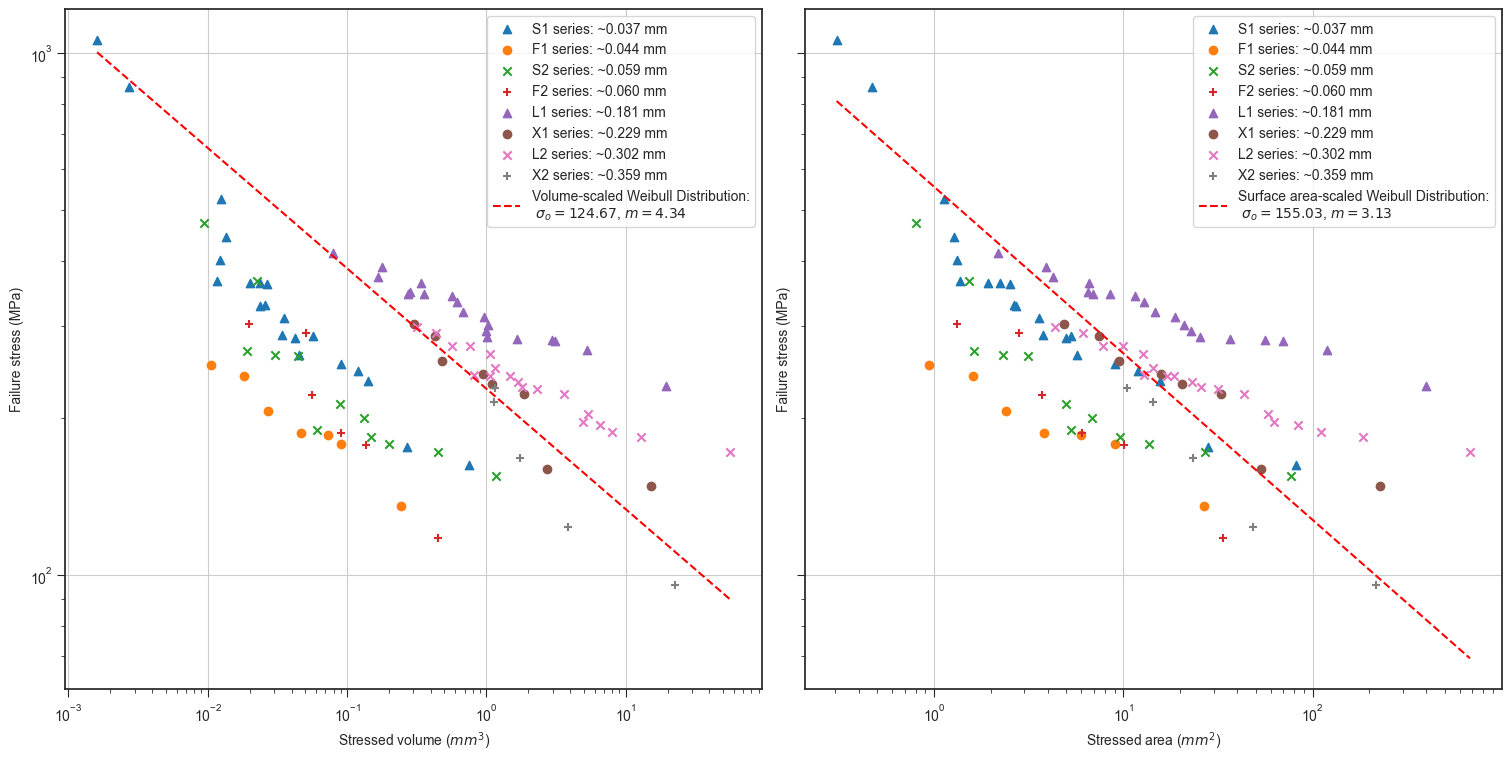

In [615]:
plot_strength_normalized_weibull(fibre_data, fibre_data_anal, weib_params_v, weib_params_sa, arbitrary_prob)

MLE scaling method: 

Scaled on volume:
Standard volume =  19.634954084936208
Weibull Scale =  27.796805562455717
Weibull Modulus =  2.5627259485805944 

Scaled on surface area:
Standard surface area =  78.53981633974483
Weibull Scale =  77.8487434213087
Weibull Modulus =  2.210735788554358


(<reliability.Distributions.Weibull_Distribution at 0x265cbd195b0>,
 <reliability.Distributions.Weibull_Distribution at 0x265cbd19940>)

<Figure size 640x480 with 0 Axes>

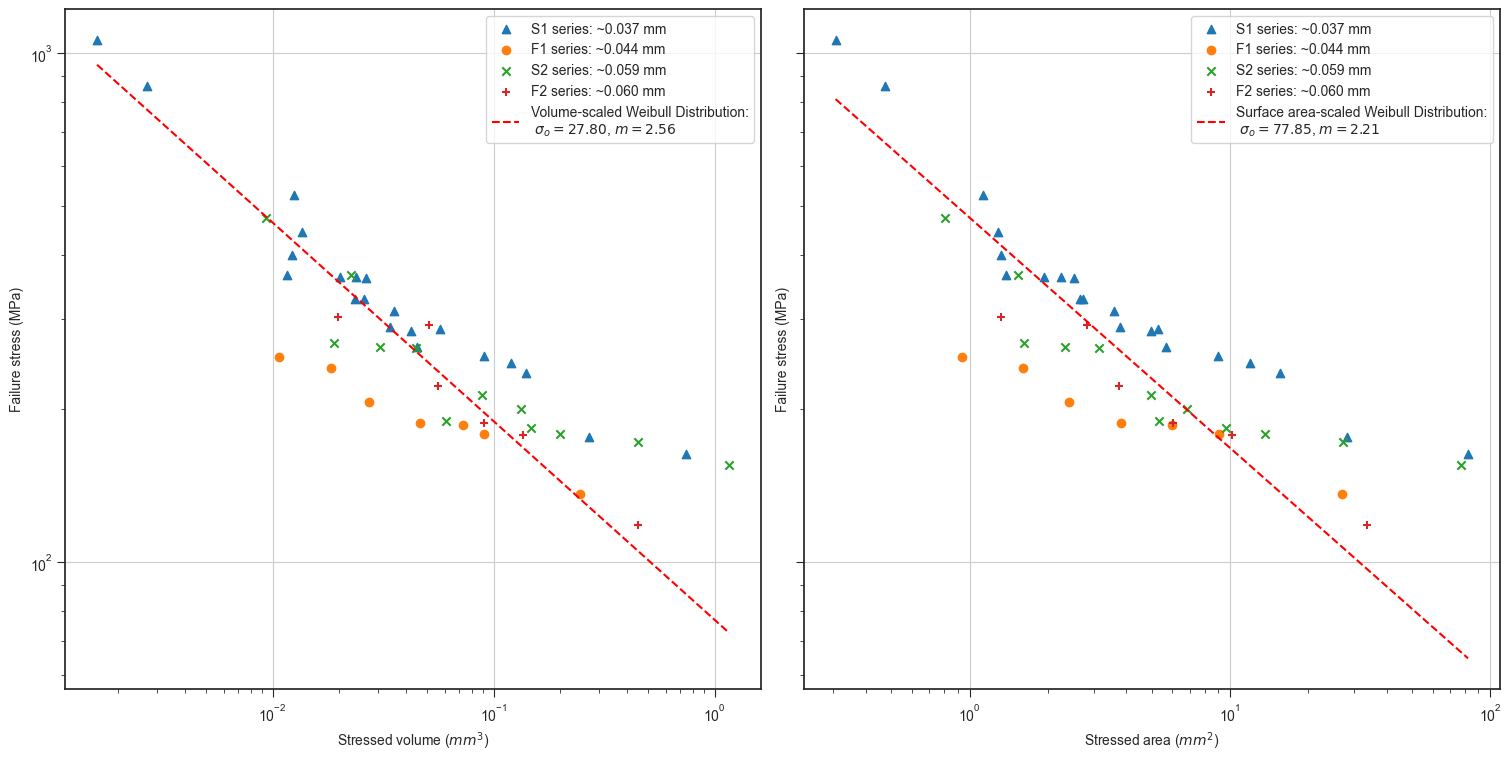

In [616]:
plot_strength_normalized_weibull(favimat_data, favimat_data_anal, favimat_weib_params_v, favimat_weib_params_sa, arbitrary_prob)

MLE scaling method: 

Scaled on volume:
Standard volume =  19.634954084936208
Weibull Scale =  159.20371152703973
Weibull Modulus =  5.214153103006061 

Scaled on surface area:
Standard surface area =  78.53981633974483
Weibull Scale =  205.2529369396619
Weibull Modulus =  4.696028408503979


(<reliability.Distributions.Weibull_Distribution at 0x265d41a3490>,
 <reliability.Distributions.Weibull_Distribution at 0x265cfc17360>)

<Figure size 640x480 with 0 Axes>

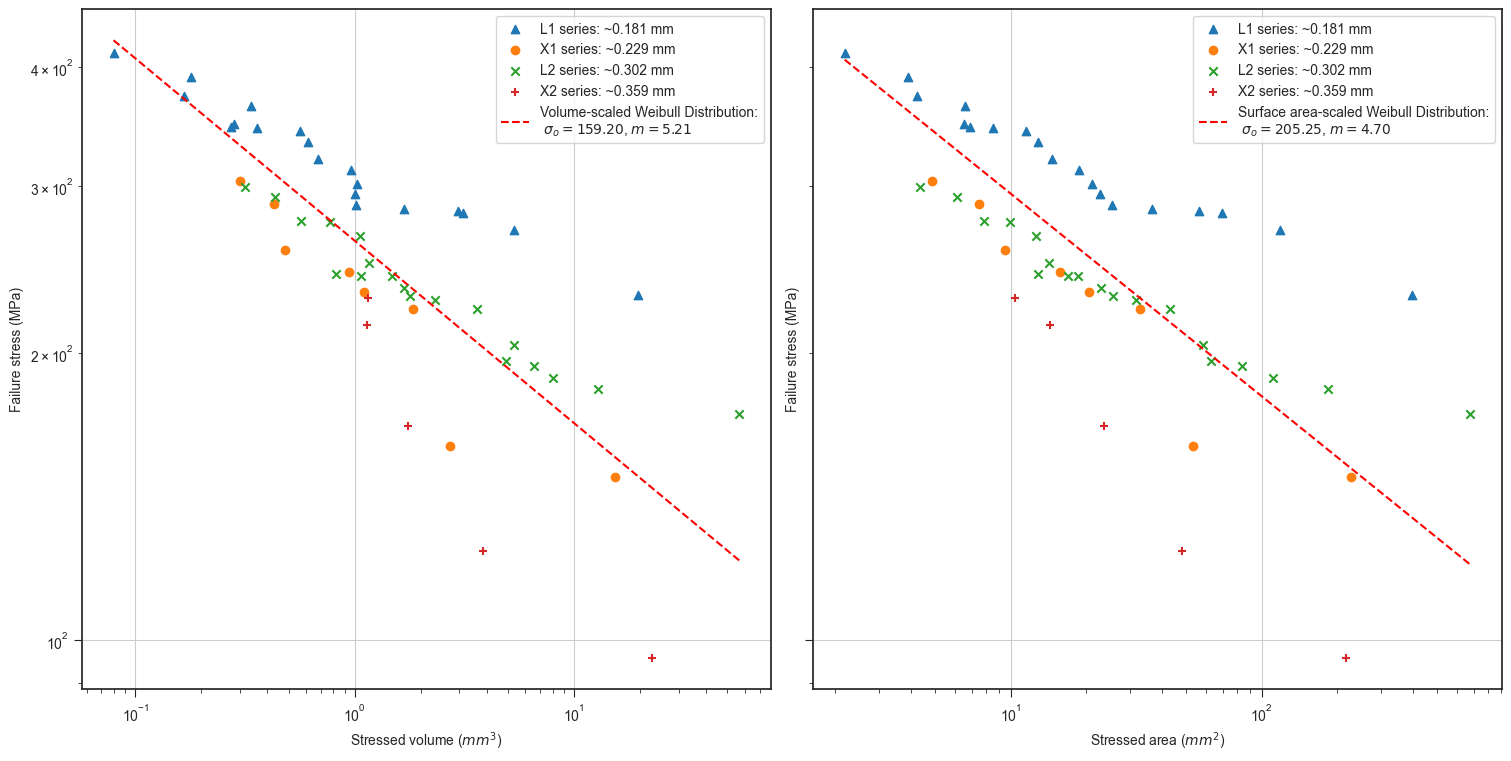

In [617]:
plot_strength_normalized_weibull(instron_data, instron_data_anal, instron_weib_params_v, instron_weib_params_sa, arbitrary_prob)

# Stiffness analysis

Weibull not applicable here, just do simple plots

In [618]:
stiff_analysis = fibre_data[["series", "%_elong_at_break", "elastic_mod"]].groupby("series").agg(['mean', "std"])
stiff_analysis.columns = stiff_analysis.columns.map('_'.join)

fibre_data_anal = fibre_data_anal.join(stiff_analysis)

fibre_data_anal["%_elong_at_break_CV"] = fibre_data_anal["%_elong_at_break_std"] / fibre_data_anal["%_elong_at_break_mean"] * 100
fibre_data_anal["elastic_mod_CV"] = fibre_data_anal["elastic_mod_std"] / fibre_data_anal["elastic_mod_mean"] * 100

In [619]:
def plot_stiffness(data):
    
    unique_series = data["series"].unique()

    fig, ax = plt.subplots()

    for series in unique_series:
            plot_data = data[data["series"] == series]
            ax.scatter(data=plot_data, x="CS_area", y="elastic_mod", label=series)

#     ax.scatter(data=fibre_data, x="CS_area", y="elastic_mod", color='k', label=None)
    # ax.errorbar(data=gcc_data_anal, x="cross_section", y="elastic_mod_mean", yerr="elastic_mod_std", fmt="none", elinewidth=1, ecolor="k", capsize=2.5, label=None)

    # cross_section = fibre_data["CS_area"].dropna().to_numpy()
    # elastic_mod = fibre_data["elastic_mod"].dropna().to_numpy()

    # fit_line_fmt = "Stiffness: \n $\\log(E) = {:0.2f} \\log(A) + {:0.2f}$"

    # m, b = np.polyfit(np.log10(cross_section), np.log10(elastic_mod), 1)

    # fit_x = np.linspace(np.min(cross_section), np.max(cross_section), 100)

    # fit_y = np.power(10, m * np.log10(fit_x) + b)

    # ax.plot(fit_x, fit_y, "--r", label=fit_line_fmt.format(m, b))

    ax.set_xlabel("Cross section size ($mm^2$)")
    ax.set_ylabel("Elastic modulus (GPa)")

    ax.grid(visible=True, which='major', linestyle='-')
    ax.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.yaxis.set_major_formatter(mticker.ScalarFormatter()) 
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

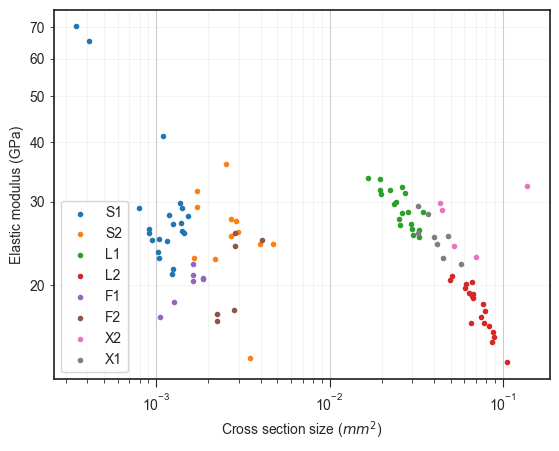

In [620]:
plot_stiffness(fibre_data)

In [621]:
def dual_stiffness(data, g1, g2):
    unique_series = data["series"].unique()

    fig, ax = plt.subplots()
    fig.set_size_inches(10,9)

    for series in unique_series:
            plot_data = data[data["series"] == series]
            ax.scatter(data=plot_data, x="CS_area", y="elastic_mod", label=series)

    cross_section = data.loc[data["series"].isin(g1),"CS_area"].dropna().to_numpy()
    elastic_mod = data.loc[data["series"].isin(g1),"elastic_mod"].dropna().to_numpy()

    fit_line_fmt = "$\\log(E) = {:0.2f} \\log(A) + {:0.2f}$"

    m, b = np.polyfit(np.log10(cross_section), np.log10(elastic_mod), 1)

    fit_x = np.linspace(np.min(cross_section), np.max(cross_section), 100)

    fit_y = np.power(10, m * np.log10(fit_x) + b)

    ax.plot(fit_x, fit_y, "--r", label=fit_line_fmt.format(m, b))

    cross_section = data.loc[data["series"].isin(g2),"CS_area"].dropna().to_numpy()
    elastic_mod = data.loc[data["series"].isin(g2),"elastic_mod"].dropna().to_numpy()

    m, b = np.polyfit(np.log10(cross_section), np.log10(elastic_mod), 1)

    fit_x = np.linspace(np.min(cross_section), np.max(cross_section), 100)

    fit_y = np.power(10, m * np.log10(fit_x) + b)

    ax.plot(fit_x, fit_y, "--b", label=fit_line_fmt.format(m, b))

    ax.set_xlabel("Cross section size ($mm^2$)")
    ax.set_ylabel("Elastic modulus (GPa)")

    ax.grid(visible=True, which='major', linestyle='-')
    ax.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.yaxis.set_major_formatter(mticker.ScalarFormatter()) 
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

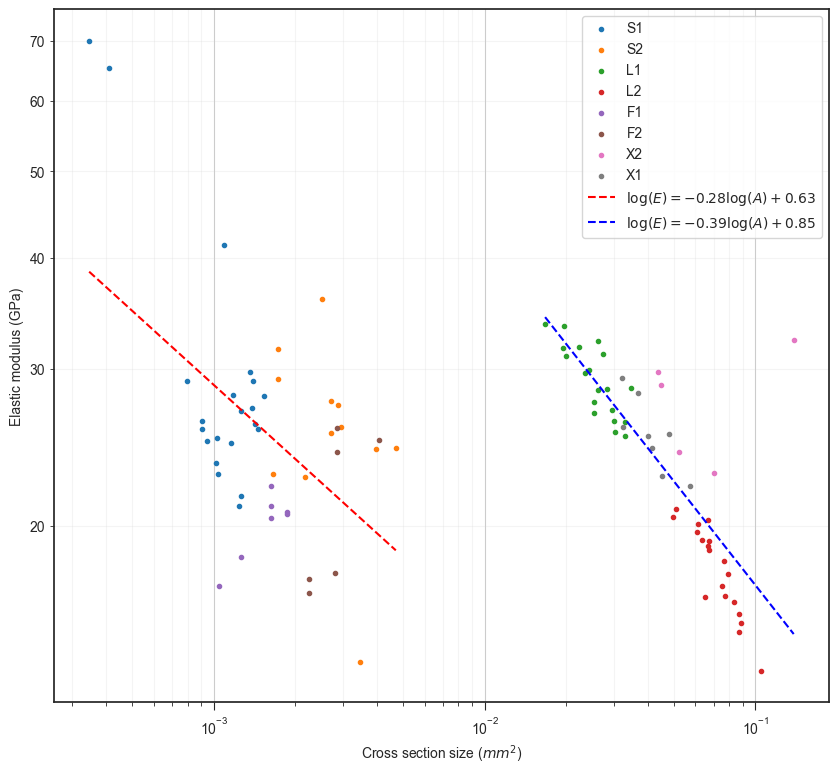

In [622]:
dual_stiffness(fibre_data, g1, g2)

In [623]:
def plot_elongation(data):
    unique_series = data["series"].unique()

    fig, ax = plt.subplots()
    fig.set_size_inches(8,7)

    for series in unique_series:
            plot_data = data[data["series"] == series]
            ax.scatter(data=plot_data, x="CS_area", y="%_elong_at_break", label=series)

    # ax.scatter(data=fibre_data, x="CS_area", y="elastic_mod", color='k', label=None)
    # ax.errorbar(data=gcc_data_anal, x="cross_section", y="elastic_mod_mean", yerr="elastic_mod_std", fmt="none", elinewidth=1, ecolor="k", capsize=2.5, label=None)

    # cross_section = fibre_data["CS_area"].dropna().to_numpy()
    # elastic_mod = fibre_data["elastic_mod"].dropna().to_numpy()

    # fit_line_fmt = "Stiffness: \n $\\log(E) = {:0.2f} \\log(A) + {:0.2f}$"

    # m, b = np.polyfit(np.log10(cross_section), np.log10(elastic_mod), 1)

    # fit_x = np.linspace(np.min(cross_section), np.max(cross_section), 100)

    # fit_y = np.power(10, m * np.log10(fit_x) + b)

    # ax.plot(fit_x, fit_y, "--r", label=fit_line_fmt.format(m, b))

    ax.set_xlabel("Cross section size ($mm^2$)")
    ax.set_ylabel("Elongation at break (%)")

    ax.grid(visible=True, which='major', linestyle='-')
    ax.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.yaxis.set_major_formatter(mticker.ScalarFormatter()) 
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

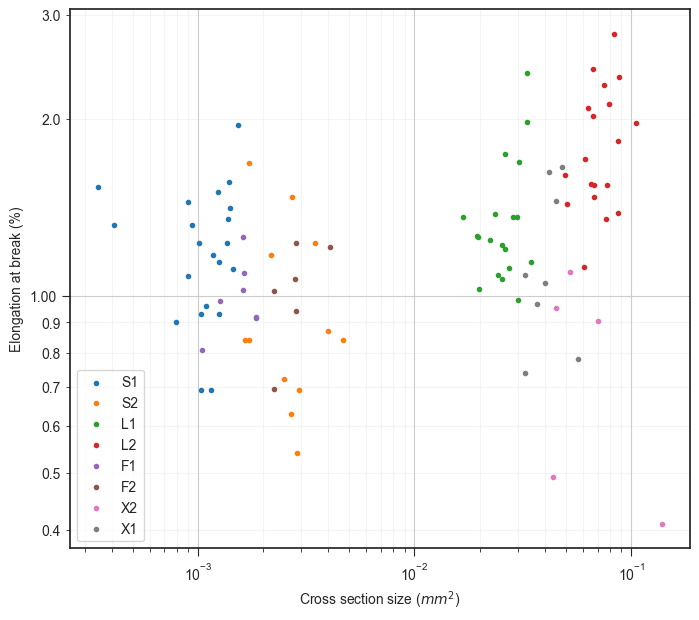

In [624]:
plot_elongation(fibre_data)

In [625]:
fibre_data_anal.to_excel("fibre_analysis_output.xlsx")